In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from random import randint
import os
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import plotting_funcs as pf
import clustering_model as cm
import config as conf

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [2]:
X = np.load('x_clean.npy')
y = np.load('y_clean.npy')
types = np.array([conf.wells_to_genetype_dict[well] for well in y])
y_letter = np.array([well[:1] for well in y])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labs = le.fit_transform(y)
labs_by_letter = le.fit_transform(y_letter)
labs_by_type = le.fit_transform(types)
X, labs
print(X.shape , labs_by_type.shape)

(3864, 32, 5) (3864,)


<AxesSubplot:>

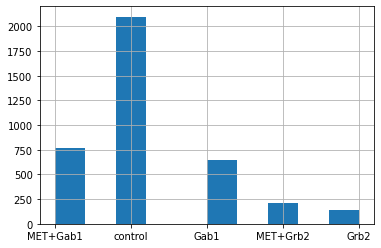

In [3]:
pd.Series(types).hist()

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,labs_by_type,test_size=0.2,random_state=42)

In [5]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3091, 32, 5) (3091,)
(773, 32, 5) (773,)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [17]:
#model params
input_dim = X_train.shape[-1]
num_labels = len(np.unique(y_train))
timesteps = X_train.shape[-2]
n_filters = [64,64,32]
kernel_size = 8
strides = 1
pool_size = 8
n_units = [64,8]

optimizer='adam'
#optimizer = Adam(lr=0.01)
#loss = 'categorical_crossentropy' # need one ot encoded labels
loss = 'sparse_categorical_crossentropy' # need label encoded labels
epochs=100
batch_size=256
save_dir='results/tmp'
verbose=1

In [18]:
classifier_model,encoder_model = cm.temporal_classifier(input_dim,num_labels,timesteps,n_filters,kernel_size,strides,pool_size,n_units)
classifier_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
classifier_model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 32, 5)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 32, 64)            2624      
                                                                 
 conv1d_10 (Conv1D)          (None, 32, 64)            32832     
                                                                 
 conv1d_11 (Conv1D)          (None, 32, 32)            16416     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32)            0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 4, 32)            0         
 1D)                                                             
                                                        

In [15]:
t0 = time()
history = classifier_model.fit(X_train, y_train,validation_data=(X_test,y_test) , batch_size=batch_size, epochs=epochs, verbose=verbose)
print('Pretraining time: ', time() - t0)

Epoch 1/30
13/13 [==============================] - 7s 144ms/step - loss: 1.3206 - accuracy: 0.5403 - val_loss: 1.2369 - val_accuracy: 0.5317
Epoch 2/30
13/13 [==============================] - 0s 36ms/step - loss: 1.2294 - accuracy: 0.5458 - val_loss: 1.2378 - val_accuracy: 0.5317
Epoch 3/30
13/13 [==============================] - 0s 34ms/step - loss: 1.2204 - accuracy: 0.5458 - val_loss: 1.2338 - val_accuracy: 0.5317
Epoch 4/30
13/13 [==============================] - 0s 34ms/step - loss: 1.2143 - accuracy: 0.5458 - val_loss: 1.2377 - val_accuracy: 0.5317
Epoch 5/30
13/13 [==============================] - 0s 35ms/step - loss: 1.2107 - accuracy: 0.5458 - val_loss: 1.2341 - val_accuracy: 0.5317
Epoch 6/30
13/13 [==============================] - 0s 38ms/step - loss: 1.2072 - accuracy: 0.5458 - val_loss: 1.2390 - val_accuracy: 0.5317
Epoch 7/30
13/13 [==============================] - 0s 35ms/step - loss: 1.2031 - accuracy: 0.5458 - val_loss: 1.2375 - val_accuracy: 0.5317
Epoch 8/30
1

In [ ]:
_, train_acc = classifier_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = classifier_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()